In [1]:
import numpy as np
import tensorflow as tf
import IPython.display
import os
import matplotlib.pyplot as plt

from tensorflow.keras import models, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
EVALUATE_ONLY = True

In [3]:
class Dataset:

    def __init__(self, path):
        self.is_loaded = False
        p = Path(path)
        if p.exists():
            print(f'Loading dataset from {path}')
            np_obj = np.load(str(p))
            self.images = np_obj['data']
            self.labels = np_obj['labels']
            self.gt_vectors = np_obj['gt_vectors']
            self.n_files = self.images.shape[0]
            self.is_loaded = True
            print(f'Done. Dataset consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label_and_gt_vector(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i], self.gt_vectors[i]

    def random_batch_with_gt_vectors(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.gt_vectors[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

In [4]:
class Metrics:

    @staticmethod
    def accuracy(gt, pred):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def print_all(gt, pred, info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))

Loading dataset from npz_trains/train2.0.npz
Done. Dataset consists of 4000 images.

Got numpy array of shape (224, 224, 3), label with code 8 and ground true vector [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


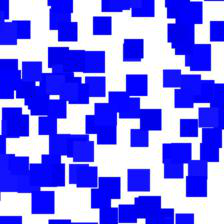

In [5]:
d_train1 = Dataset('npz_trains/train2.0.npz')

img, lbl, gt_vector = d_train1.random_image_with_label_and_gt_vector()
print()
print(f'Got numpy array of shape {img.shape}, label with code {lbl} and ground true vector {gt_vector}')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

In [6]:
class MySimpleClassifier:

    def __init__(self, n_output_channels, n_filters):
        self.model = models.Sequential()
        self.model.add(Input(shape=(224, 224, 3)))
        self.model.add(Conv2D(n_filters, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(n_filters, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(n_filters * 2, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(n_filters * 2, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(n_filters * 4, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(n_filters * 4, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(GlobalAveragePooling2D())

        self.model.add(Flatten())
        self.model.add(Dense(n_output_channels, activation='softmax'))

    def save(self, name: str):
        # save model with name 'name'
        p = Path(name)
        self.model.save(str(p))

    def load(self, name: str):
        # load model with name 'name'
        p = Path(name)
        self.model = models.load_model(str(p))

    def train(self, dataset: Dataset, val_images, val_gt_vectors):
        print(f'training started')
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
        self.model.fit(dataset.images,
                       dataset.gt_vectors,
                       epochs=10,
                       validation_data=(val_images, val_gt_vectors))
        print(f'training done')

    def test_on_dataset(self, dataset: Dataset):
        predictions = []
        for img in tqdm(dataset.images_seq(), total=dataset.n_files):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        prediction = np.argmax(self.model.predict(np.expand_dims(img, axis=0)))
        return prediction


In [7]:
d_train1 = Dataset('npz_trains/train2.0.npz')

Loading dataset from npz_trains/train2.0.npz
Done. Dataset consists of 4000 images.


In [8]:
val_images, val_gt_vectors = d_train1.random_batch_with_gt_vectors(int(d_train1.n_files * 0.2))

In [12]:
model = MySimpleClassifier(20, 8)
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 16)      6

In [13]:
if EVALUATE_ONLY:
    model.train(d_train1, val_images, val_gt_vectors)
    model.save('model_trained_on_scale_2.0')
else:
    model.load('best')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/10
4000/4000 [==============================] - 30s 7ms/sample - loss: 1.2924 - accuracy: 0.6710 - val_loss: 2.0652 - val_accuracy: 0.2950
Epoch 2/10
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.4175 - accuracy: 0.9460 - val_loss: 0.7074 - val_accuracy: 0.7375
Epoch 3/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.1515 - accuracy: 0.9915 - val_loss: 0.1956 - val_accuracy: 0.9937
Epoch 4/10
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.0662 - accuracy: 0.9987 - val_loss: 0.1071 - val_accuracy: 0.9675
Epoch 5/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 6/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.0318 - accuracy: 0.9980 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 7/10
4000/4000 [==============================] 

In [36]:
FOLDER = 'npz_tests'

accuraces = []
model.load('model_trained_on_scale_2.0')

for root, dirs, files in os.walk(FOLDER):
    for filename in files:
        dtest = Dataset(FOLDER + '\\' + filename)
        pred = model.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))
        print(accuraces)

Loading dataset from npz_tests\test0.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239]
Loading dataset from npz_tests\test0.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975]
Loading dataset from npz_tests\test0.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125]
Loading dataset from npz_tests\test0.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625]
Loading dataset from npz_tests\test0.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755]
Loading dataset from npz_tests\test1.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335]
Loading dataset from npz_tests\test1.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852]
Loading dataset from npz_tests\test1.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085]
Loading dataset from npz_tests\test1.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795]
Loading dataset from npz_tests\test1.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996]
Loading dataset from npz_tests\test1.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995]
Loading dataset from npz_tests\test1.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0]
Loading dataset from npz_tests\test1.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0]
Loading dataset from npz_tests\test1.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test1.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test10.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15]
Loading dataset from npz_tests\test10.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15]
Loading dataset from npz_tests\test2.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0]
Loading dataset from npz_tests\test2.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0]
Loading dataset from npz_tests\test2.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test2.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test2.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test2.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test2.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test2.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test2.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test2.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test3.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test4.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test4.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Loading dataset from npz_tests\test4.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985]
Loading dataset from npz_tests\test4.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885]
Loading dataset from npz_tests\test4.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665]
Loading dataset from npz_tests\test4.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485]
Loading dataset from npz_tests\test4.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295]
Loading dataset from npz_tests\test4.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907]
Loading dataset from npz_tests\test4.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894]
Loading dataset from npz_tests\test4.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878]
Loading dataset from npz_tests\test5.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805]
Loading dataset from npz_tests\test5.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742]
Loading dataset from npz_tests\test5.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708]
Loading dataset from npz_tests\test5.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663]
Loading dataset from npz_tests\test5.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285]
Loading dataset from npz_tests\test5.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085]
Loading dataset from npz_tests\test5.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705]
Loading dataset from npz_tests\test5.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544]
Loading dataset from npz_tests\test5.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511]
Loading dataset from npz_tests\test5.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965]
Loading dataset from npz_tests\test6.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483]
Loading dataset from npz_tests\test6.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451]
Loading dataset from npz_tests\test6.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075]
Loading dataset from npz_tests\test6.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525]
Loading dataset from npz_tests\test6.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309]
Loading dataset from npz_tests\test6.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825]
Loading dataset from npz_tests\test6.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27]
Loading dataset from npz_tests\test6.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595]
Loading dataset from npz_tests\test6.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25]
Loading dataset from npz_tests\test6.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445]
Loading dataset from npz_tests\test7.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385]
Loading dataset from npz_tests\test7.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195]
Loading dataset from npz_tests\test7.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975]
Loading dataset from npz_tests\test7.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845]
Loading dataset from npz_tests\test7.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755]
Loading dataset from npz_tests\test7.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665]
Loading dataset from npz_tests\test7.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655]
Loading dataset from npz_tests\test7.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16]
Loading dataset from npz_tests\test7.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155]
Loading dataset from npz_tests\test7.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152]
Loading dataset from npz_tests\test8.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151]
Loading dataset from npz_tests\test8.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505]
Loading dataset from npz_tests\test8.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15]
Loading dataset from npz_tests\test8.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505]
Loading dataset from npz_tests\test8.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15]
Loading dataset from npz_tests\test8.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15]
Loading dataset from npz_tests\test8.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test8.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test8.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test8.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.0.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.1.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.2.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.3.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.4.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.5.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.6.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.7.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.8.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
Loading dataset from npz_tests\test9.9.npz
Done. Dataset consists of 2000 images.


  0%|          | 0/2000 [00:00<?, ?it/s]

[0.239, 0.2975, 0.4125, 0.5625, 0.6755, 0.8335, 0.852, 0.9085, 0.9795, 0.996, 0.9995, 1.0, 1.0, 1.0, 1.0, 0.15, 0.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 0.9885, 0.9665, 0.9485, 0.9295, 0.907, 0.894, 0.878, 0.805, 0.742, 0.708, 0.663, 0.6285, 0.6085, 0.5705, 0.544, 0.511, 0.4965, 0.483, 0.451, 0.4075, 0.3525, 0.309, 0.2825, 0.27, 0.2595, 0.25, 0.2445, 0.2385, 0.2195, 0.1975, 0.1845, 0.1755, 0.1665, 0.1655, 0.16, 0.155, 0.152, 0.151, 0.1505, 0.15, 0.1505, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]


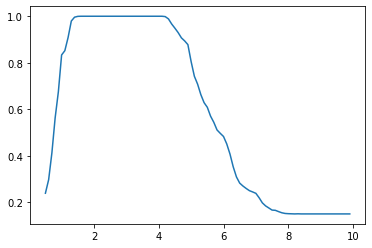

In [52]:
xpoints = np.arange(0.5, 10.0, 0.1)
ypoints = np.array(accuraces)
# print(xpoints.shape, ypoints.shape)
plt.plot(xpoints, ypoints)
plt.show()

In [10]:
light_model = MySimpleClassifier(20, 4)
light_model.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 4)       112       
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 4)       16        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 4)       148       
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 4)       16        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 4)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 8)       296       
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 8)      

In [11]:
light_model.train(d_train1, val_images, val_gt_vectors)
light_model.save('light_model_trained_on_scale_2.0')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/10
4000/4000 [==============================] - 20s 5ms/sample - loss: 2.0198 - accuracy: 0.4493 - val_loss: 2.3864 - val_accuracy: 0.3088
Epoch 2/10
4000/4000 [==============================] - 14s 4ms/sample - loss: 1.1844 - accuracy: 0.7750 - val_loss: 1.3227 - val_accuracy: 0.7613
Epoch 3/10
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.7536 - accuracy: 0.8608 - val_loss: 0.7758 - val_accuracy: 0.8238
Epoch 4/10
4000/4000 [==============================] - 14s 3ms/sample - loss: 0.4900 - accuracy: 0.9442 - val_loss: 0.6103 - val_accuracy: 0.8250
Epoch 5/10
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.3231 - accuracy: 0.9795 - val_loss: 0.2568 - val_accuracy: 0.9962
Epoch 6/10
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.1975 - accuracy: 0.9975 - val_loss: 0.1531 - val_accuracy: 1.0000
Epoch 7/10
4000/4000 [==============================] 

In [ ]:
FOLDER = 'npz_tests'

accuraces = []
model.load('light_model_trained_on_scale_2.0')

for root, dirs, files in os.walk(FOLDER):
    for filename in files:
        dtest = Dataset(FOLDER / filename)
        pred = model.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))